In [1]:
from darts.datasets import ETTh1Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator

from einops import rearrange, repeat, reduce

np.random.seed(123)

In [2]:
class ESN(BaseEstimator):

    def __init__(self, reservoir_size=100, input_size=1, output_size=1,  spectral_radius=1.0, connectivity_rate=1.0, epochs=1, lr=0.01, leaky_parameter=1.0, washout=1):
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.epochs = epochs
        self.connectivity_rate = connectivity_rate
        self.lr = lr
        self.spectral_radius = spectral_radius
        self.washout = washout
        self.leaky_parameter = leaky_parameter
        self.output_size = output_size
        

        self.state = np.zeros((self.reservoir_size, 1))
        self.W_in = np.random.rand(reservoir_size, input_size)
        self.W_in, _ = np.linalg.qr(self.W_in)
        self.W_out = None

        # ## Initializing Reservoir Weights according to original paper(2001).
        # ##
        # ## Initialize a random matrix and induce sparsity 
        # self.W_res = np.random.randn(reservoir_size, reservoir_size)
        # self.W_res[np.random.rand(*self.W_res.shape) > self.connectivity_rate] = 0

        # ##  Scale the matrix based on user defined spectral radius.
        # current_spectral_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        # self.W_res = self.W_res * (self.spectral_radius / current_spectral_radius)


        ## Initializing Reservoir Weights according to "Re-visiting the echo state property"(2012)
        ##
        ## Initialize a random matrix and induce sparsity.
        self.W_res = np.random.rand(reservoir_size, reservoir_size)
        self.W_res[np.random.rand(*self.W_res.shape) > self.connectivity_rate] = 0

        ## Scale the matrix based on user defined spectral radius.
        current_spectral_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res = self.W_res * (self.spectral_radius / current_spectral_radius)

        ## Induce half of the weights as negative weights.
        total_entries = self.W_res.size
        num_negative_entries = total_entries//2
        negative_indices = np.random.choice(total_entries, num_negative_entries, replace=False)
        W_flat = self.W_res.flatten()
        W_flat[negative_indices] *= -1
        self.W_res = W_flat.reshape(self.W_res.shape)


        self.all_states = [self.state]

    @staticmethod
    def activation(x):
         
        ## Hyperbolic Tangent Function
         return np.tanh(x)

        # ## ReLU Fuction
        # return np.clip(x, 0, np.inf)
    
        # ## Sigmoid Function
        # return 1 / (1 + np.exp(-x))


    def fit(self, X_train, y_train):
        
        ## Epochs are useless. Keep it as 1 always.
        for _ in range(self.epochs): 

            ## Reset states.
            state_collection_matrix = np.zeros((self.input_size + self.reservoir_size, 1))
            # self.state = np.zeros((self.reservoir_size, 1))

            ## Calculate state of reservoirs per time step
            for i in range(X_train.shape[0]-1):

               

                input = X_train[i].reshape(-1,1)
                input_product = self.W_in@input
                state_product = self.W_res@self.state
                self.state = self.activation(input_product + state_product)
                state_collection_matrix= np.hstack((state_collection_matrix, np.concatenate((self.state, input))))

                self.all_states.append(self.state)

            ## Update W_out
            mat1 = state_collection_matrix.T[self.washout:,:]
            # ridge_regressor= Ridge(alpha=self.lr)
            # ridge_regressor.fit(mat1, y_train[self.washout:,:])
            # self.W_out = ridge_regressor.coef_
            

            self.W_out = np.linalg.lstsq(mat1,y_train[self.washout:,:])[0].T


    # def predict(self, X_test):
    #         input_product = self.W_in@X_test
    #         state_product = self.W_res@self.state
    #         self.state = np.tanh(input_product + state_product)
    #         concat_matrix= np.concatenate((self.state, X_test))
    #         pred =  self.W_out@concat_matrix
    #         return pred
    
    def predict(self, X_test):
            prediction = np.zeros((1,1))
            for i in range(X_test.shape[0]- 1):
                input = X_test[i].reshape(-1,1)
                input_product = self.W_in@input
                state_product = self.W_res@self.state
                self.state = self.activation(input_product + state_product)
                concat_matrix= np.concatenate((self.state, input))
                pred =  self.W_out@concat_matrix
                prediction = np.hstack([prediction, pred])

                self.all_states.append(self.state)
            
            prediction = rearrange(prediction, 'c r -> r c')
            return prediction
    


In [3]:
dataset = ETTh1Dataset()
time_series = dataset.load()
time_series.head(5)

<TimeSeries (DataArray) (date: 5, component: 7, sample: 1)> Size: 280B
array([[[ 5.82700014],
        [ 2.00900006],
        [ 1.59899998],
        [ 0.46200001],
        [ 4.20300007],
        [ 1.34000003],
        [30.53100014]],

       [[ 5.69299984],
        [ 2.07599998],
        [ 1.49199998],
        [ 0.426     ],
        [ 4.1420002 ],
        [ 1.37100005],
        [27.78700066]],

       [[ 5.15700006],
        [ 1.74100006],
        [ 1.27900004],
        [ 0.35499999],
        [ 3.77699995],
        [ 1.21800005],
        [27.78700066]],

       [[ 5.09000015],
        [ 1.94200003],
        [ 1.27900004],
        [ 0.391     ],
        [ 3.80699992],
        [ 1.27900004],
        [25.04400063]],

       [[ 5.3579998 ],
        [ 1.94200003],
        [ 1.49199998],
        [ 0.46200001],
        [ 3.86800003],
        [ 1.27900004],
        [21.94799995]]])
Coordinates:
  * date       (date) datetime64[ns] 40B 2016-07-01 ... 2016-07-01T04:00:00
  * component  (component) object 56B 'HUFL' 'HULL' 'MUFL' ... 'LULL' 'OT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

(12194, 6) (5226, 6)
(12194,) (5226,)


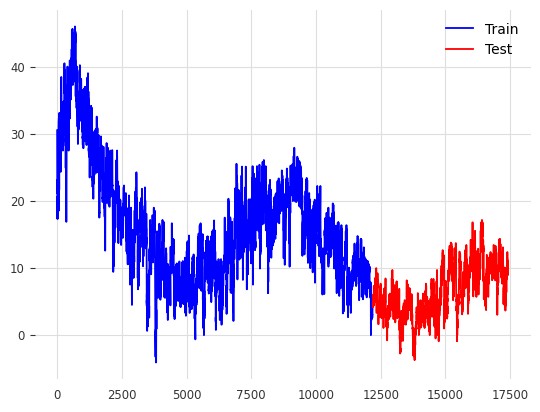

In [4]:
## Train and Test Splitting of Time Series Data
data = time_series.values()
X = data[:,:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


plt.figure()
plt.plot(np.arange(len(y_train)), y_train, c='blue', label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()

In [5]:
sc1 = MinMaxScaler()
sc2 = MinMaxScaler()

y_train = rearrange(y_train, 'r -> r 1')
y_test = rearrange(y_test, 'r -> r 1')

# print( y_train.shape, y_test.shape)

X_train_std = sc1.fit_transform(X_train)
X_test_std = sc1.transform(X_test)

y_train_std = sc2.fit_transform(y_train)
y_test_std = sc2.transform(y_test)

print(X_train_std.shape, X_test_std.shape, y_train_std.shape, y_test_std.shape)

(12194, 6) (5226, 6) (12194, 1) (5226, 1)


In [6]:
esn = ESN(reservoir_size=20, input_size=6, output_size=1, spectral_radius=0.7, connectivity_rate=0.8, washout=1)

esn.fit(X_train_std, y_train_std)

/tmp/ipykernel_39966/1185514380.py:94: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W_out = np.linalg.lstsq(mat1,y_train[self.washout:,:])[0].T


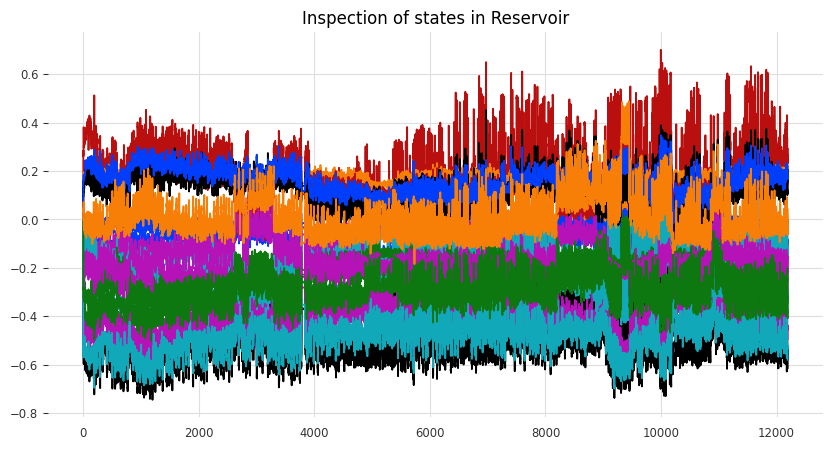

In [7]:
states = np.array(esn.all_states)
states = rearrange(states, 'r c 1 -> r c')
states.shape

plt.figure(figsize=(10,5))
plt.plot(states)
plt.title("Inspection of states in Reservoir")
plt.show()

In [8]:

predictions = esn.predict(X_test_std)
predictions.shape
print("MSE:", np.sqrt(mean_squared_error(y_test_std, predictions)))
print("MAE:", mean_absolute_error(y_test_std, predictions))
print("MAPE:",mean_absolute_percentage_error(y_test_std, predictions))

MSE: 0.27131957808376217
MAE: 0.25041109327488603
MAPE: 1.640659377547902


In [9]:
predictions_scaled = sc2.inverse_transform(predictions)
print("MSE:", np.sqrt(mean_squared_error(predictions_scaled, y_test_std)))
print("MAE", mean_absolute_error(predictions_scaled, y_test_std))
print("MAPE", mean_absolute_percentage_error(predictions_scaled, y_test_std))

MSE: 19.12492321913313
MAE 18.683303942179432
MAPE 0.9883553116052705


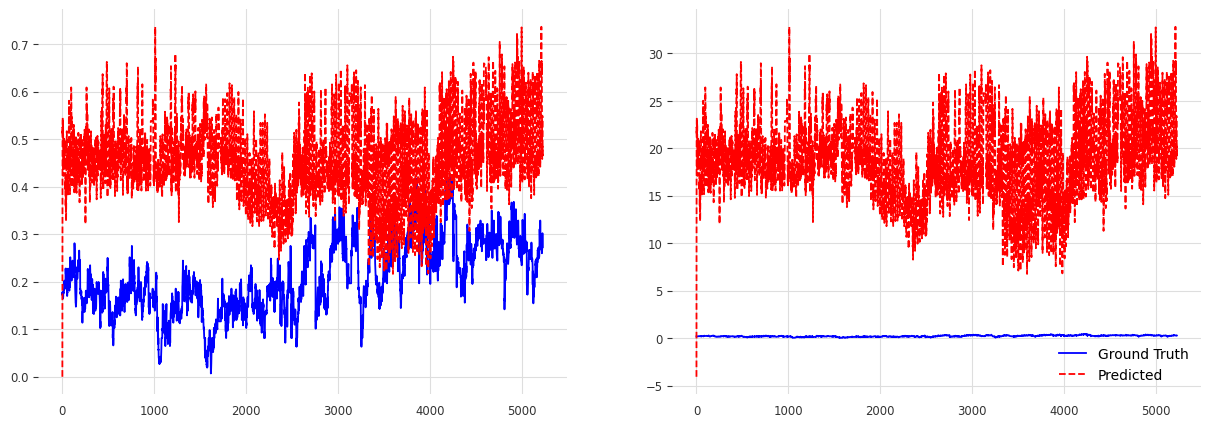

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(y_test_std, label="Ground Truth", c="blue")
axs[0].plot(predictions, label="Predicted", c="red", linestyle="--")

axs[1].plot(y_test_std, label="Ground Truth", c="blue")
axs[1].plot(predictions_scaled, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()